# 基盤技術開発テクニック練習ノートブック
## 2021年度ver

## このノートブックについて
数式の実装には多くの解があります．例えば，行列演算の実装はfor文によって要素ずつ計算する方法と行列計算ライブラリによって計算する方法と大きく分けて二通りがあります．

このノートブックでは古川研究室でよく使われる行列演算のテクニックをできるだけ網羅してまとめました．またそれを実際に実行できながら体系的に理解・学習できるようになることを目標に作りました．

修正事項
- argminの説明が演繹的
- jax, einsumの実装がまだ

## 事前知識
このノートブックでも必要再現の操作は抑えますが，事前知識として以下の本を読むことを推奨します．

[Dropboxにpdf](https://www.dropbox.com/s/7r6cbcux1br1jhb/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BPython%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_pass.pdf?dl=0)があるので手元におくのを推奨します．

- 「ゼロからつくるPython機械学習プログラミング入門」
  - chapter2：Python入門
  - chapter3：数学のおさらい


## 準備
### [Numpy](https://numpy.org/doc/stable/user/index.html)

NumpyはPythonで科学的な計算を行うための基本的なパッケージです。行列計算は機械学習に限らず数値計算の基本であり，Numpyはその行列計算を高速に計算します．

In [2]:
# numpyをimportします． as npで短縮してnpという名前で使うのが一般的です．
import numpy as np

In [252]:
# 5次元の単位行列を作ります．
A = np.eye(5)

# 中身を確認します．
print(A)
# 配列のサイズを確認します． (5, 5)は 5x５の行列になっているという意味です． 
# また， jupyterではセルの最後の行はprint()と括らなくても出力されます．
A.shape

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


(5, 5)

### [Matplotlib](https://)
MatplotlibはPythonの描画パッケージです． （描画の実装で悩むのはアルゴリズムの実装と理解にはあまり関係ないので，困ったら知ってる人に効くことをおすすめします．）

In [253]:
import matplotlib.pyplot as plt

N = 10 # データ数
D = 2 # 次元数

# 二次元データをN個つくります．
X = np.arange(N*D).reshape(N,D)
print(X, X.shape)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]] (10, 2)


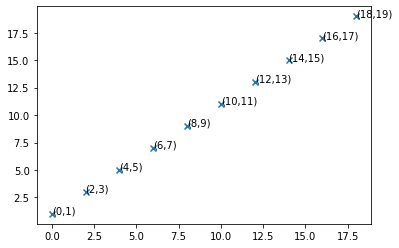

In [254]:
# 散布図(scatter)で描画します． 
## 第一引数にはx座標の値のベクトル．第二引数にはy座標の値のベクトルをいれます．
plt.scatter(X[:,0], X[:,1], marker='x')
[plt.text(X[n,0], X[n,1], "("+str(X[n,0])+","+str(X[n,1])+")") for n in range(N)]
print("")

### Jax, Jaxlib

自動微分パッケージです．

In [260]:
import jax,jaxlib

### Scipy
一般的な機械学習のライブラリです．

In [261]:
import scipy

## 目次
0. リシェイプ(reshape)
1. ブロードキャスト（Broadcast）
2. メッシュグリッド(Meshgrid)
3. アーグミン(Argmin)
4. ファンシィインデックス(Fancy index)
5. アインサム(Einsum)

### 0. Reshape
さっきでてきた
> X = np.arange(N*D).reshape(N,D)

これです．

[reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)はデータの形（サイズ）を変更するときに使います．

In [258]:
# xxx, yyy を適当な整数に変えて実行してください
N, D = xxx, yyy
# N, D = 8, 2

# NxD次元ベクトルを作ります．
X = np.arange(N*D)
print("Xのshapeは", X.shape, N*D,"次元ベクトル（",N*D,"個要素がある）ということです．")
print(X)
X_m = X.reshape(N,D)
print("\n")
print("これに対して, N, D =",N,",",D,"として X.reshape(N,D)とすると", X_m.shape,"の行列になります")

NameError: name 'xxx' is not defined

In [259]:
print("また，逆にベクトルに戻すには以下のようにする．")

print('X.reshape(-1)', X.reshape(-1))

また，逆にベクトルに戻すには以下のようにする．
X.reshape(-1) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


#### 演習問題0
以上の操作を任意の行列で実践せよ．

### 1. Broadcast
詳しい定義は[上島さんの解説記事](https://www.kamishima.net/mlmpyja/nbayes2/broadcasting.html).
使い方やイメージが欲しいなら[ここ](https://deepage.net/features/numpy-broadcasting.html).

In [26]:
I = 3
J = 4
A = np.arange(I)[:, None] + 1
print("Aのshapeは",A.shape," で，A自体は",'\n',A, "\n")
B = np.arange(I*J).reshape(I,J)
print("Bのshapeは",B.shape," で，B自体は",'\n', B, "\n")

print("この行列A,Bに対して B-A という演算をすると","\n", B - A,"となる")

# B - A

Aのshapeは (3, 1)  で，A自体は 
 [[1]
 [2]
 [3]] 

Bのshapeは (3, 4)  で，B自体は 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]] 

この行列A,Bに対して B-A という演算をすると 
 [[-1  0  1  2]
 [ 2  3  4  5]
 [ 5  6  7  8]] となる


行列演算はシェイプが違う行列同士の演算は定義されていない（というかできない）が， Broadcastをサポートしているライブラリではある条件を満たした場合特殊な演算ができる（されてしまう）．

今回のケース:
A行列(shape:(3,1))とB行列(shape:(3,4))はshapeが違うので演算できない． 
Broadcastでは， A行列(3,1)を列方向にコピーしてA_hat(3,4)の行列を作ってB - A_hatの演算をおこなう．

In [27]:
print("具体的には 以下のような演算をする")
A_hat = np.tile(A, J)
print("A_hat:","\n",A_hat)
print("B - A_hat:", "\n", B - A_hat,"\n", "先ほどの B-Aの演算と一致する．")

具体的には 以下のような演算をする
A_hat: 
 [[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]]
B - A_hat: 
 [[-1  0  1  2]
 [ 2  3  4  5]
 [ 5  6  7  8]] 
 先ほどの B-Aの演算と一致する．


#### 演習問題1-a 
列方向のコピーではなく，行方向のコピーが行われるBroadcastの計算を実装せよ． (任意の四則演算）

In [237]:
C = np.arange(J)[None, :]
B * C

ValueError: operands could not be broadcast together with shapes (11,) (1,4) 

#### 演習問題1-b 
先ほどは行列(shapeが(I, J)のような変数）に対しての演算であった．3階のテンソルの変数（shapeが （I,J,K））に対して，任意のBroadcastの計算を実装せよ．

In [29]:
K = 2
D = np.arange(I*J*K).reshape(I,J,K)
E1 = np.arange(I*J).reshape(I,J,1)
E2 = np.arange(I*K).reshape(I,1,K)
print(D-E1,"\n",D-E2)

[[[ 0  1]
  [ 1  2]
  [ 2  3]
  [ 3  4]]

 [[ 4  5]
  [ 5  6]
  [ 6  7]
  [ 7  8]]

 [[ 8  9]
  [ 9 10]
  [10 11]
  [11 12]]] 
 [[[ 0  0]
  [ 2  2]
  [ 4  4]
  [ 6  6]]

 [[ 6  6]
  [ 8  8]
  [10 10]
  [12 12]]

 [[12 12]
  [14 14]
  [16 16]
  [18 18]]]


### 2. Meshgrid

[Meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)は，座標ベクトルを入力すると座標行列を返してくれる関数です．

以下のような軸をx,y軸を想定して，そこにそれぞれ等間隔に点が打たれているとします．

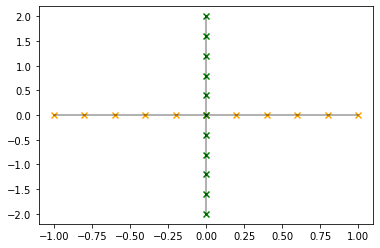

In [106]:
K = 11
A = np.linspace(-1,1,K)
B = np.linspace(-2,2,K)
plt.plot([A[-1], A[0]], [0,0], color='black', alpha=0.4)
plt.plot([0,0],[B[-1], B[0]], color='black', alpha=0.4)
plt.scatter(A,np.zeros(A.shape), color='orange', marker='x')
plt.scatter(np.zeros(B.shape),B, color='g', marker='x')

この点からそれぞれ垂直線をひくと以下の図のようなグリッドが描くことができます．

meshgrid関数は以下のような図の格子点(交わっているところ）の座標を取得したいときに使われる関数です．

この緑線とオレンジ線の交点の座標を求めます


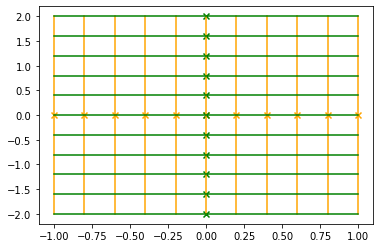

In [112]:
plt.scatter(A,np.zeros(A.shape), color='orange', marker='x')
plt.scatter(np.zeros(B.shape),B, color='g', marker='x')
[plt.plot(np.tile(A[i],K), B, color='orange') for i in range(K)]
[plt.plot(A, np.tile(B[i], K),  color='g') for i in range(K)]
print("この緑線とオレンジ線の交点の座標を求めます")

In [117]:

XX, YY = np.meshgrid(A,B)

print("二つのベクトルを入力すると二つの行列が返ってきます．")
print("XXのshapeは", XX.shape, 'YYのshapeは', YY.shape, "となる")
print("XX")
print(XX)
print("YY")
print(YY)

二つのベクトルを入力すると二つの行列が返ってきます．
XXのshapeは (11, 11) YYのshapeは (11, 11) となる
XX
[[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]]
YY
[[-2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2. ]
 [-1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6]
 [-1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2]
 [-0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8]
 [-0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0

$XX_{ij}$にはx=i,y=-jの交点のx座標が， $YY_{ij}$にはx=i,y=-jの交点のy座標が格納されている，
言い換えると， x=i, y=-jの交点の座標は$( XX_{ij}, YY_{ij} )$ です．

meshgridを使うと，交点の座標の数値は得られました．ここからは使いやすい形に二つの行列を整形します．
使いやすい形とはいわゆるデータ行列のような(交点の数， 次元数）というような二次元配列です．つまり，

$M = \\
[(XX_{11}, YY_{11}),\\(XX_{12}, YY_{12}), \\(XX_{13}, YY_{13}), \\ \cdots, \\(XX_{KK}, YY_{KK)}] $

のような 
$\mathbf{R}^{(K*K)\times 2} = \mathbf{R}^{(P \times 2)} , P = K*K$の二次元行列$M$に整形します．
言い換えると，$M = ( \mathbf{m_p} )_{p=1}^{P}, \mathbf{m} \in \mathbb{R}^2$となります． 


まず，XXとYYは (K, K)のような二次元配列である必要ではないので， reshapeを使ってKxKの行列をM次元ベクトルに直します． 
次に， 1次元ベクトルxxとyyを横方向に結合するために， reshapeされた xx, yyを(M, 1)の行列に整形して，concatenateします．

In [32]:
xx = XX.reshape(-1)
yy = YY.reshape(-1)
M = np.concatenate([xx[:,None], yy[:,None]], axis=1)
M.shape

(121, 2)

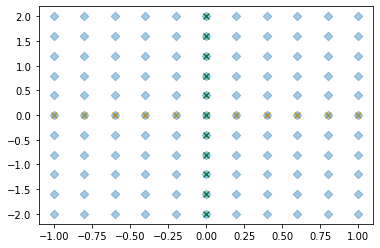

In [50]:
plt.scatter(A,np.zeros(A.shape), color='orange', marker='x')
plt.scatter(np.zeros(B.shape),B, color='g', marker='x')
plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D')

格子点行列Mができました．

#### 演習問題2

以上の操作を任意のベクトルの格子点で実践せよ

### 3. Argmin, Argmax

>数学において、最大値を与える引数あるいは最大点集合 (argument of the maximum) は関数がその最大値をとる定義域の元全体の成す集合である[note 1]。省略してarg max (もしくは argmax) と書かれる。最大値が函数の出力のうち最も大きいものを指すのと対照に、最大点は最大値を出力する入力の値を指す。
最大点集合は一般に複数の元を含むが、それは有限集合であることも無限集合であることも起こり得るし、空となることもあり得る。

上が一応定義ですがとりあえず以下の例をみながら理解していきましょう．

例えば，先ほどのような格子点は以下のようなインデックスを持つ．

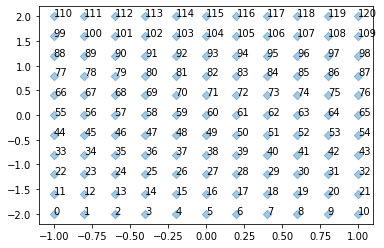

In [128]:
plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D')
[plt.text(M[n, 0], M[n, 1], str(n)) for n in range(K*K)]
print("")

さらに，この空間に以下のような新規点$\mathbf{x}_n$ができたとします．

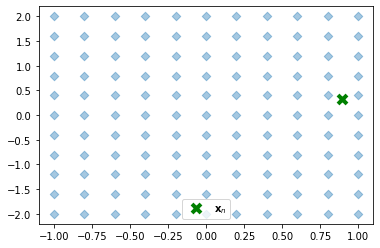

In [222]:
np.random.seed(6)
x = np.random.rand(2).reshape(1,2)

plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D')
plt.scatter(x[:, 0], x[:, 1], s=80, color='g', marker='x', label='$\mathbf{x}_n$', linewidths=4)
plt.legend()
# plt.text(X[:, 0]+0.05, X[:, 1], "$\mathbf{x}^*$", color='g', size=25)

$\newcommand{\argmax}{\mathop{\rm arg~max}\limits}$
$\newcommand{\argmin}{\mathop{\rm arg~min}\limits}$

ここでは， $\mathbf{x}_n$とそれに一番近い$\mathbf{m}_{k^*_n}$の点を求めます． 
${k^*_n}$は$n$番目のデータに対して一番近い$\mathbf{m}$のインデックスで勝者ノード番号とも呼ばれます（格子点の節のインデックス（番号）なのでノード番号とも呼ばれる）．
離散点はずっと固定なので，この勝者ノード番号を求めれば，一番近い点を求めたことになります．

この操作はを数式で書くと，
$k^*_n = \argmin_k D(\mathbf{x}_n, \mathbf{m}_k)$

$D(\mathbf{a},\mathbf{b})$は$\mathbf{a}$と$\mathbf{b}$の距離を返す関数で， $D(\mathbf{a},\mathbf{b})=\|\mathbf{a} - \mathbf{b} \|^2$とすると，

$k^*_n = \argmin_k \|\mathbf{x}_n - \mathbf{m}_k\|^2$ となります．


In [223]:
print(x.shape, M.shape)
Dist = np.sum((x[:, None, :] - M[None, :, :])**2, axis=2)
print(Dist.shape)

k_star = np.argmin(Dist)

k_star

(1, 2) (121, 2)
(1, 121)


75

データ$\mathbf{x}_n$に対応する勝者ノード番号は 75でした．

なので$\mathbf{x}_n$に対応する座標を$\mathbf{z}_n$とおくと

$\mathbf{z}_n := \mathbf{m}_{75}$

ということです

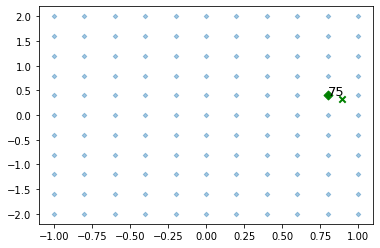

In [228]:
plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D', s=10)

z_n = M[k_star] 
plt.text(z_n[0], z_n[1], str(k_star), fontsize=13) 
# plt.text(M[k_star, 0], M[k_star, 1], str(k_star), fontsize=13) 

plt.scatter(z_n[0], z_n[1],  marker='D', s=40, color='g')
plt.scatter(x[:, 0], x[:, 1], s=40, color='g', marker='x', label='$\mathbf{x}_n$', linewidths=2)
print("")

データに一番近い格子点のインデックスが表示され，データと同じ色に着色されているのが確認できたと思います．


では次にデータ１点ではなく，N点で考えます．
データ集合$X = \{ \mathbf{x}_n\}_{n=1}^N$は以下のように生成されます．

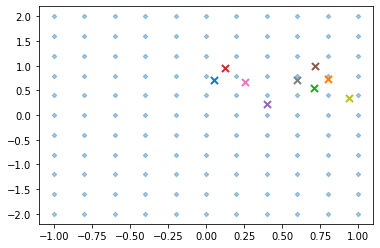

In [234]:
N = 9
X = np.random.rand(N*2).reshape(N,2)
cmap = plt.get_cmap("tab10") 

plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D', s=10)
for n in range(N):
    plt.scatter(X[n, 0], X[n, 1], color=cmap(n), s=50, marker='x', linewidths=2)

データ集合$X$に対応する勝者ノード集合$K^* = \{ k_n^*\}_{n=1}^N$は以下のように求めます．

In [236]:
print(X.shape, M.shape)
Dist = np.sum((X[:, None, :] - M[None, :, :])**2, axis=2)
print(Dist.shape)

K_star = np.argmin(Dist, axis=1)

K_star

(9, 2) (121, 2)
(9, 121)


array([82, 86, 75, 83, 73, 86, 83, 85, 76])

さらに，勝者ノード集合を用いて，データ集合$X$に対応するノード集合$Z = \{ \mathbf{m}_{k_n^*}\}_{n=1}^N$は描画します．

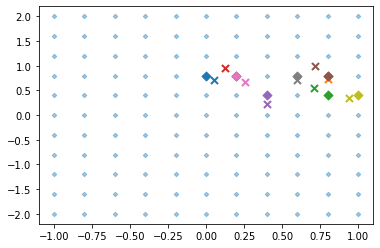

In [238]:
plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D', s=10)
for n in range(N):
    plt.scatter(X[n, 0], X[n, 1], color=cmap(n), s=50, marker='x', linewidths=2)
    
    z_n = M[K_star[n]]
    
    plt.scatter(z_n[0], z_n[1], marker='D', s=40, color=cmap(n))
#     plt.scatter(M[K_star[n], 0], M[K_star[n], 1], marker='D', s=40, color=cmap(n))

データに一番近いノードはそのデータの色になっていることがわかります（勝者ノードが重複している場合は上書きされる）

### 4. Fancy index

先ほど，データ集合$X$に対応するノード集合$Z$を求めるのにfor文を用いて実装した

つまり，

$\forall n, \mathbf{z}_n := \mathbf{m}_{k_n^*}$
`for n in range(N):
    z_n = M[K_ster[n]]`

とした．

これをfor文で求めないのに用いるのが Fancy Indexである．

イメージとしては以下のような数式になる．
$Z = M[K^*]$

In [267]:
Z = M[K_star]
Z, Z.shape, M[0:14,:], M.shape, K_star, len(K_star)

(array([[0. , 0.8],
        [0.8, 0.8],
        [0.8, 0.4],
        [0.2, 0.8],
        [0.4, 0.4],
        [0.8, 0.8],
        [0.2, 0.8],
        [0.6, 0.8],
        [1. , 0.4]]),
 (9, 2),
 array([[-1. , -2. ],
        [-0.8, -2. ],
        [-0.6, -2. ],
        [-0.4, -2. ],
        [-0.2, -2. ],
        [ 0. , -2. ],
        [ 0.2, -2. ],
        [ 0.4, -2. ],
        [ 0.6, -2. ],
        [ 0.8, -2. ],
        [ 1. , -2. ],
        [-1. , -1.6],
        [-0.8, -1.6],
        [-0.6, -1.6]]),
 (121, 2),
 array([82, 86, 75, 83, 73, 86, 83, 85, 76]),
 9)

以下，未実装誰かやってくれ
### 5. Einsum
UKRとTSOMの実装にあったら便利なテクニックです．
### 6. Jax
UKRの実装にあったら便利なテクニックです．



## 実装
ここでは，上で得た知識を使って様々な計算を実装していく

### I.距離行列


#### I.a 一次元空間
データ$A=\{a_n\}_{n=1}^N$と構造$B=\{b_k\}_{k=1}^K$の要素の間の距離を測れ．

つまり， $D_{ij} = Dist(a_i, b_j)$ のような距離行列(N x K)を求めよ．

*$Dist(a,b)$は$a,b$を入力として実数を返す距離関数．ここでは任意の距離関数を用いて良い．

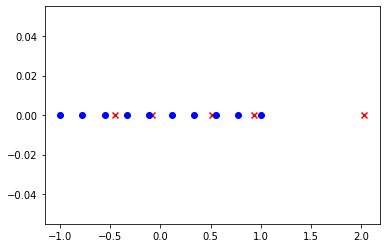

In [288]:
N, K = 5, 10
A = np.random.randn(N)
B = np.linspace(-1,1, K)
plt.scatter(A, np.zeros(len(A)), color='r', marker='x')
plt.scatter(B, np.zeros(len(B)), color='b')

#### I.b 二次元空間
データ$A=\{\mathbf{a}_n\}_{n=1}^N, \mathbf{a}\in \mathbb{R}^2$と構造$B=\{\mathbf{b}_k\}_{k=1}^K,\mathbf{b}\in \mathbb{R}^2$の要素の間の距離を測れ．



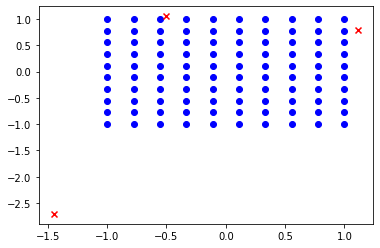

In [289]:
N, K = 3, 10
D = 2
A = np.random.randn(N,D).reshape(N,D)
b = np.linspace(-1,1, K)
xx, yy = np.meshgrid(b, b)
B = np.concatenate([xx.reshape(-1)[:, None], yy.reshape(-1)[:, None]], axis=1)
plt.scatter(B[:,0], B[:,1], color='b')
plt.scatter(A[:,0], A[:,1], color='r', marker='x')

#### I.c 任意次元数の空間
データ$A=\{\mathbf{a}_n\}_{n=1}^N, \mathbf{a}\in \mathbb{R}^D$と構造$B=\{\mathbf{b}_k\}_{k=1}^K,\mathbf{b}\in \mathbb{R}^D$の要素の間の距離を測れ．

データと構造を定義するところからはじめよ．処理に任意の次元に対応できるようすればいいだけで，次元数は３でよい．